# Банки — Сегментация пользователей по потреблению

Задачи проекта:
- Провести исследовательский анализ данных;
- Сформировать портреты пользователей на основе данных о количестве потребляемых продуктов;
- Сформулировать и проверить 2 статистические гипотезы:


1) Проверить гипотезу о различии доходов между клиентами, которые пользуются двумя продуктами банка, и клиентами, которые пользуются одним.

2) Проверить гипотезу о различии количетсва баллов скоринга, у клиентов, которые пользуются двумя продуктами банка, и клиентами, которые пользуются одним.

- Сделать общий вывод и предложить рекомендации для удержания клиентов.
- Ссылка на презентацию: https://www.canva.com/design/DAEvCX-4gdo/1RaoeufuVo5-H3qxgTUVLQ/view?utm_content=DAEvCX-4gdo&utm_campaign=designshare&utm_medium=link&utm_source=sharebutton
- Ссылка на дашборд: https://public.tableau.com/app/profile/zorun/viz/Book3_16362773254090/Sheet3?publish=yes

## Шаг №1. Загрузка данных и подготовка их к анализу

In [1]:
#импортируем необходимые библиотеки

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
from scipy import stats as st

In [2]:
bank = pd.read_csv('/datasets/bank_dataset.csv')
bank.head(5)

,userid,score,City,Gender,Age,Objects,Balance,Products,CreditCard,Loyalty,estimated_salary,Churn
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1
1,15690047,608,Рыбинск,Ж,41,1,83807.86,1,0,1,112542.58,0
2,15662040,502,Ярославль,Ж,42,8,159660.80,3,1,0,113931.57,1
3,15744090,699,Ярославль,Ж,39,1,NaN,2,0,0,93826.63,0
4,15780624,850,Рыбинск,Ж,43,2,125510.82,1,1,1,79084.10,0


In [3]:
# Проверим таблицу на дубликаты
bank.duplicated().sum()

0

In [4]:
# посмотрим основную информацию по таблице bank
bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
userid              10000 non-null int64
score               10000 non-null int64
City                10000 non-null object
Gender              10000 non-null object
Age                 10000 non-null int64
Objects             10000 non-null int64
Balance             6383 non-null float64
Products            10000 non-null int64
CreditCard          10000 non-null int64
Loyalty             10000 non-null int64
estimated_salary    10000 non-null float64
Churn               10000 non-null int64
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


Типы данных соотвествуют данным для каждого из столбцов.

### Вывод

Таблица имеет 10 000 сток и 12 столбцов:

- userid — идентификатор пользователя,
- score — баллы кредитного скоринга (рейтинг одобрения кредита от 350 до 850 баллов),
- City — город,
- Gender — пол,
- Age — возраст,
- Objects — количество объектов в собственности,
- Balance — баланс на счёте,
- Products — количество продуктов, которыми пользуется клиент,
- CreditCard — наличие кредитной карты, где 1 - есть, 0 - нет.
- Loyalty — активный клиент, где 1 - да, 0 - нет.
- estimated_salary — заработная плата клиента,
- Churn — параметр оттока, где 1 - ушёл, 0 - остался.

В таблице нет дубликатов, типы данных соотвествуют данным для каждого из столбцов.

## Шаг №2. Исследовательский анализ данных

Есть пропуски в столбце с балансом, рассмотрим поподробнее.

In [5]:
bank[bank['Balance'].isnull()]

,userid,score,City,Gender,Age,Objects,Balance,Products,CreditCard,Loyalty,estimated_salary,Churn
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1
3,15744090,699,Ярославль,Ж,39,1,NaN,2,0,0,93826.63,0
6,15635267,822,Ярославль,М,50,7,NaN,2,1,1,10062.80,0
11,15779909,497,Рыбинск,М,24,3,NaN,2,1,0,76390.01,0
12,15675000,476,Ярославль,Ж,34,10,NaN,2,1,0,26260.98,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9989,15648358,841,Рыбинск,М,28,4,NaN,2,1,1,179436.60,0
9992,15699841,726,Рыбинск,М,36,2,NaN,1,1,0,195192.40,0
9994,15762030,800,Ярославль,Ж,29,2,NaN,2,0,0,167773.55,0
9995,15648965,771,Ярославль,М,39,5,NaN,2,1,0,96270.64,0


In [6]:
# Посмотрим в разрезе по наличию кредитной карты, сколько продуктов клиенты имеют в банке
bank.groupby('CreditCard')['Products'].value_counts()

CreditCard  Products
0           1           1506
            2           1344
            3             76
            4             19
1           1           3578
            2           3246
            3            190
            4             41
Name: Products, dtype: int64

In [7]:
# Сделаем такой же разрез, но для клиентов у которых в поле баланса пропущенное значение
bank[bank['Balance'].isnull()].groupby('CreditCard')['Products'].value_counts()

CreditCard  Products
0           2            742
            1            248
            3             30
            4              5
1           2           1858
            1            657
            3             68
            4              9
Name: Products, dtype: int64

В столбце с балансом есть 3617 пропущенных значений (36%), это большой показатель, потому я не могу их удалить. Заменить их на среднее или медиану тоже "опасно", т.к. я не вижу закономерности. 

In [8]:
# Посмотрим основные числовые характеристики для нашей таблицы
bank.describe()

,userid,score,Age,Objects,Balance,Products,CreditCard,Loyalty,estimated_salary,Churn
count,1.000000e+04,10000.000000,10000.000000,10000.000000,6383.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,1.573368e+07,650.528800,38.921800,5.012800,119827.493793,1.530200,0.70550,0.515100,100090.239881,0.203700
std,7.193619e+04,96.653299,10.487806,2.892174,30095.056462,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.560844e+07,350.000000,18.000000,0.000000,3768.690000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,1.567126e+07,584.000000,32.000000,3.000000,100181.975000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,1.573347e+07,652.000000,37.000000,5.000000,119839.690000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,1.579597e+07,718.000000,44.000000,7.000000,139512.290000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,1.585843e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [9]:
# Посмотрим в разрезе по параметру оттока, сколько активных клиентов в банке
bank.groupby('Churn')['Loyalty'].value_counts()

Churn  Loyalty
0      1          4416
       0          3547
1      0          1302
       1           735
Name: Loyalty, dtype: int64

Столбец Score (кредитный скоринг), где минимальное 350 и максимальное 850, среднее и медиана составляют 650. Это говорит о том, что больше 50% клиентов имеют кредитный скоринг с возможностью одобрения 54% (если 350 брать за 0% и 850  за 100%)

Столбец Age (возраст) имеет медиану в 37 лет, и среднее в 39 лет. Это говорит о том, что есть клиенты с большим возрастом, которые меняют среднее. Максимальный возвраст в таблице 92 года.

Столбец Objects (кол-во объектов в собственности) имеет среднее и медианное в 5 объектов на клиента.

Столбец Balance (баланс на счете) имеет и среднюю и медиану в 119 800 рублей.

Столбец Products (количество продуктов, каким пользуется клиент) имеет среднее в 1,5 продукта, и медиану в 1. Это говорит о том, что есть небольшая группа клиентов, которая пользуется большим количеством продуктов, чем большинство и тем самым меняют среднее значение.

Столбец CreditCard (наличие кредитной карты) указывает среднее 0,7, значит 70% клиентов имеют кредитную карту.

Столбец Loyalty (активный клиент, где 1 - да, 0 - нет) указывает среднее 0,51, что говорит о том, что 51% клиентов активны.

Столбец estimated_salary (заработная плата клиента) имеет среднее и медиану в 100 000 рублей.

Столбец Churn (параметр оттока клиента, где 1 - что клиент покинул банк, 0 - является его клиентом на данный момент) имеет среднее в 0,2, что означает, что только 20% клиентов закрыли все свои счета в данном банке. Из данных 20%: 13% не были активными клиентами, возможно они уже давно не пользовались услугами банка, и 7% были активными клиентами и закрыли все свои счета.

### Вывод

В столбце с балансом есть 3617 пропущенных (36%). Это большой показатель, потому я не могу их удалить. Заменить их на среднее или медиану тоже "опасно", т.к. я не вижу закономерности. 

Могу предположить следующие причины появления пропусков:

- Есть какое-то количество клиентов, которые не пользуются услугами банка, который подразумевает баланс на счёте. Например, только кредит или ипотека.
- В таблице есть новые клиенты, которые ещё не успели пополнить баланс на момент выгрузки.
- Возможно была и какая-то техническая ошибка при выгрузке.

По основным числовым характеристикам можем сделать следующие выводы:
 - Средний возраст клиентов от 37 до 39 лет.
 - В среднем клиент имеет 5 объектов в собственности, зарплату в 100 000 рублей и баланс на счёте в 120 000.
 - 70% клиентов имеют кредиткую карту.
 - 51% клиентов являются активными пользователями банка.
 - В основном клиеты пользуются только один продуктом банка, и небольшая группа людей пользуется большим количеством продуктов.
 - 20% клиентов закрыло все расчётные счета в данном банке, из них на момент выгрузки только 7% являлись активными пользователями услуг банка. 13% на момент выгрузки были неактивными клиентами.

## Шаг 3. Описание портретов пользователей на основе данных о количестве потребляемых продуктов

In [10]:
# Посмотрим основные числовые характеристики для нашей таблицы для клиентов, какие используют один продукт банка
bank[bank.Products == 1].describe()

,userid,score,Age,Objects,Balance,Products,CreditCard,Loyalty,estimated_salary,Churn
count,5.084000e+03,5084.000000,5084.000000,5084.000000,4179.000000,5084.0,5084.000000,5084.000000,5084.000000,5084.000000
mean,1.573237e+07,649.120968,39.673092,4.974626,119894.163723,1.0,0.703777,0.504131,99487.256851,0.277144
std,7.216578e+04,97.203710,10.659566,2.914269,29804.134035,0.0,0.456636,0.500032,57363.626412,0.447632
min,1.560844e+07,350.000000,18.000000,0.000000,12459.190000,1.0,0.000000,0.000000,11.580000,0.000000
25%,1.566940e+07,581.000000,32.000000,2.000000,100440.185000,1.0,0.000000,0.000000,50414.515000,0.000000
50%,1.573206e+07,651.000000,38.000000,5.000000,119919.120000,1.0,1.000000,1.000000,99226.830000,0.000000
75%,1.579434e+07,717.000000,45.000000,7.000000,139442.110000,1.0,1.000000,1.000000,148212.695000,1.000000
max,1.585843e+07,850.000000,92.000000,10.000000,238387.560000,1.0,1.000000,1.000000,199970.740000,1.000000


In [11]:
# Посмотрим в разрезе по параметру оттока, сколько активных клиентов, использующих 1 продукт банка
bank[bank.Products == 1].groupby('Churn')['Loyalty'].value_counts()

Churn  Loyalty
0      1          2078
       0          1597
1      0           924
       1           485
Name: Loyalty, dtype: int64

Все столбцы показывают те же показатели, что и для всей таблице. 

Только в столбце Churn (момент оттока) указывает, что из клиентов, пользующихся одинм продуктом банка, 27% закрыло все расчётные счёта, из них 9% клиентов были активными пользователями. 18% на момент выгрузки были неактивными клиентами

In [12]:
# Посмотрим основные числовые характеристики для нашей таблицы для клиентов, какие используют два продукта банка
bank[bank.Products == 2].describe()

,userid,score,Age,Objects,Balance,Products,CreditCard,Loyalty,estimated_salary,Churn
count,4.590000e+03,4590.000000,4590.000000,4590.000000,1990.000000,4590.0,4590.000000,4590.000000,4590.000000,4590.000000
mean,1.573484e+07,652.188671,37.753595,5.051852,119660.944362,2.0,0.707190,0.532898,100452.012821,0.075817
std,7.156542e+04,96.066831,10.145663,2.867741,30647.376666,0.0,0.455102,0.498971,57790.799984,0.264734
min,1.560845e+07,350.000000,18.000000,0.000000,3768.690000,2.0,0.000000,0.000000,90.070000,0.000000
25%,1.567420e+07,586.000000,31.000000,3.000000,99179.367500,2.0,0.000000,0.000000,50797.287500,0.000000
50%,1.573578e+07,653.000000,36.000000,5.000000,119762.245000,2.0,1.000000,1.000000,100738.855000,0.000000
75%,1.579700e+07,719.000000,42.000000,7.000000,139556.932500,2.0,1.000000,1.000000,150151.460000,0.000000
max,1.585838e+07,850.000000,92.000000,10.000000,214346.960000,2.0,1.000000,1.000000,199992.480000,1.000000


In [13]:
# Посмотрим в разрезе по параметру оттока, сколько активных клиентов, использующих 2 продукта банка
bank[bank.Products == 2].groupby('Churn')['Loyalty'].value_counts()

Churn  Loyalty
0      1          2310
       0          1932
1      0           212
       1           136
Name: Loyalty, dtype: int64

Клиенты, которые имеют два продукта банка, отличаются чуть более молодым возрастом 36-38 лет, когда для всей таблицы характерен возраст 37-39.

Активность состаляет 53% против 51% по всей таблице.

И среди данных клиентов всего 7% пользователей закрыло все расчётные счета, их которых активных было всего 3%. 4% на момент выгрузки уже являлись неактивными клиентами.

In [14]:
# Посмотрим основные числовые характеристики для нашей таблицы для клиентов, какие используют три продукта банка
bank[bank.Products == 3].describe()

,userid,score,Age,Objects,Balance,Products,CreditCard,Loyalty,estimated_salary,Churn
count,2.660000e+02,266.000000,266.000000,266.000000,168.000000,266.0,266.000000,266.000000,266.000000,266.000000
mean,1.574182e+07,648.105263,43.195489,5.003759,119475.686310,3.0,0.714286,0.424812,104318.130564,0.827068
std,7.395279e+04,95.190396,10.422008,2.879332,31504.871935,0.0,0.452606,0.495246,55464.281426,0.378902
min,1.560905e+07,358.000000,21.000000,0.000000,43772.660000,3.0,0.000000,0.000000,3440.470000,0.000000
25%,1.568224e+07,586.000000,36.000000,3.000000,100741.587500,3.0,0.000000,0.000000,64344.800000,1.000000
50%,1.574438e+07,650.000000,42.000000,5.000000,118118.190000,3.0,1.000000,0.000000,101046.885000,1.000000
75%,1.580754e+07,711.000000,50.000000,8.000000,139714.815000,3.0,1.000000,1.000000,152230.195000,1.000000
max,1.585823e+07,850.000000,77.000000,10.000000,250898.090000,3.0,1.000000,1.000000,199357.240000,1.000000


In [15]:
# Посмотрим в разрезе по параметру оттока, сколько активных клиентов, использующих 2 продукта банка
bank[bank.Products == 3].groupby('Churn')['Loyalty'].value_counts()

Churn  Loyalty
0      1           28
       0           18
1      0          135
       1           85
Name: Loyalty, dtype: int64

Клиенты, которые используют 3 продукта банка, имеют более зрелый возраст, 42-43 года, когда для всей таблицы характерен возраст 37-39 лет.

Активность состаляет 49% против 51% по всей таблице.

Также у данных клиентов высокий отток, который составляет 82,7%, из которых 50% были активными пользователями. 32,7% данных клиентов на момент выгрузки являлось неактивными клиентами.

In [16]:
# Посмотрим основные числовые характеристики для нашей таблицы для клиентов, какие используют четыре продукта банка
bank[bank.Products == 4].describe()

,userid,score,Age,Objects,Balance,Products,CreditCard,Loyalty,estimated_salary,Churn
count,6.000000e+01,60.000000,60.000000,60.000000,46.000000,60.0,60.000000,60.000000,60.000000,60.0
mean,1.571936e+07,653.583333,45.683333,5.300000,122260.610870,4.0,0.683333,0.483333,104763.723333,1.0
std,6.814840e+04,101.265600,8.619040,2.947564,27761.150772,0.0,0.469102,0.503939,57526.494114,0.0
min,1.561074e+07,376.000000,29.000000,1.000000,46870.430000,4.0,0.000000,0.000000,5669.310000,1.0
25%,1.566638e+07,595.000000,40.000000,2.750000,112063.295000,4.0,0.000000,0.000000,62033.390000,1.0
50%,1.570775e+07,643.000000,45.000000,5.000000,120968.270000,4.0,1.000000,0.000000,112163.105000,1.0
75%,1.576341e+07,708.000000,50.250000,8.000000,135527.207500,4.0,1.000000,1.000000,139371.955000,1.0
max,1.585805e+07,850.000000,68.000000,10.000000,195238.290000,4.0,1.000000,1.000000,198874.520000,1.0


In [17]:
# Посмотрим в разрезе по параметру оттока, сколько активных клиентов, использующих 2 продукта банка
bank[bank.Products == 4].groupby('Churn')['Loyalty'].value_counts()

Churn  Loyalty
1      0          31
       1          29
Name: Loyalty, dtype: int64

Клиенты, у которых есть 4 продукта банка, имеют возраст 45-46 лет, когда для всей таблицы характерен возраст 37-39 лет.

Активность состаляет 48% против 51% по всей таблице.

Они имеют чуть более высокий заработок в 104-112 тысячи рублей, против 100 тысяч рублей для всей таблицы.

Также их отток составляет 100% из которых, 48% на момент выгрузки были активными пользователями.

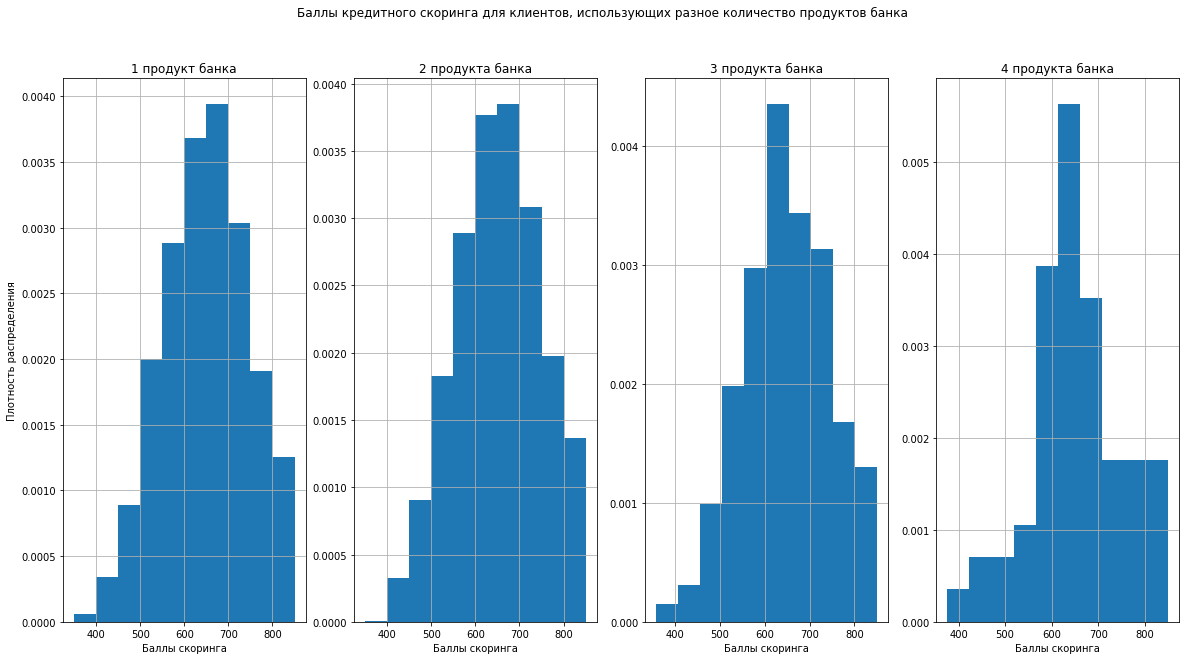

In [18]:
# Создадим таблицу с клиентами, использующих 1 продукт
bank_1 = bank[bank.Products == 1]

# Создадим таблицу с клиентами, использующих 2 продукта
bank_2 = bank[bank.Products == 2]

# Создадим таблицу с клиентами, использующих 3 продукта
bank_3 = bank[bank.Products == 3]

# Создадим таблицу с клиентами, использующих 4 продукта
bank_4 = bank[bank.Products == 4]

# Создадим рисунок с 4 графиками в ряд
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 10))

# Построим гистрограмму для столбца с годом выпуска

bank_1['score'].hist(density=True, ax=axes[0])
bank_2['score'].hist(density=True, ax=axes[1])
bank_3['score'].hist(density=True, ax=axes[2])
bank_4['score'].hist(density=True, ax=axes[3])

# Добавим подписи для каждой колонки 
axes[0].set_title('1 продукт банка')
axes[0].set_xlabel('Баллы скоринга')
axes[0].set_ylabel('Плотность распределения')
axes[1].set_title('2 продукта банка')
axes[1].set_xlabel('Баллы скоринга')
axes[2].set_title('3 продукта банка')
axes[2].set_xlabel('Баллы скоринга')
axes[3].set_title('4 продукта банка')
axes[3].set_xlabel('Баллы скоринга')

# Добавим общий заголовок
fig.suptitle('Баллы кредитного скоринга для клиентов, использующих разное количество продуктов банка');

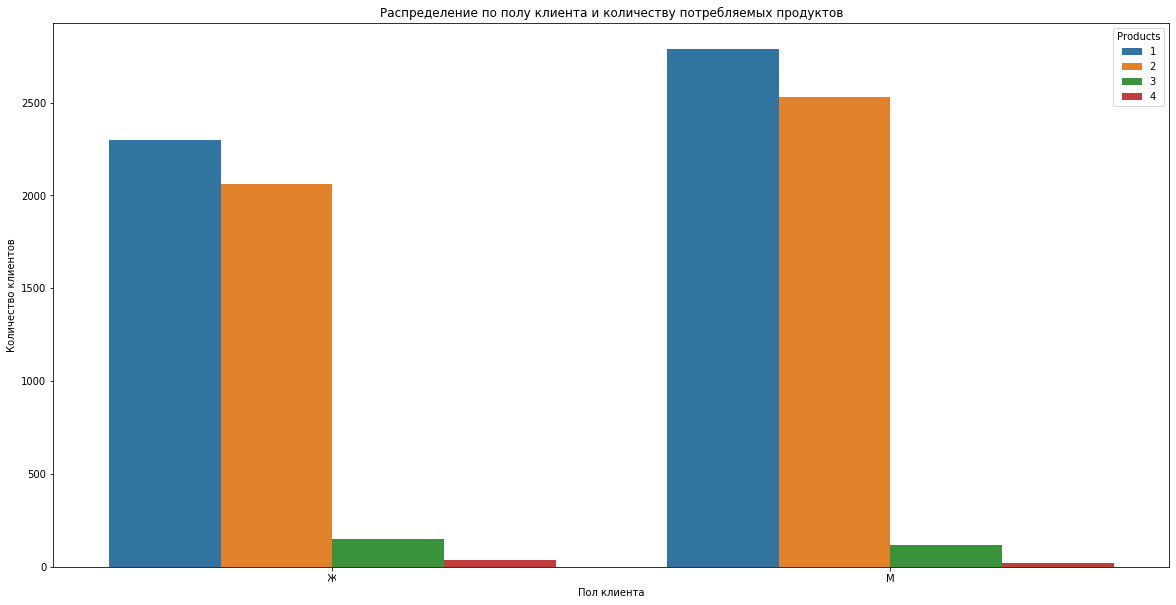

In [19]:
# Построим столбчатые график по признаку пола для клиентов, использующих разное количество продуктов банка
fig = plt.figure(figsize=(20,10))

sns.barplot(data=bank.groupby(['Gender', 'Products']).agg({'Objects': 'count'}).reset_index(),
            x='Gender',y='Objects',hue='Products');


# Добавим подписи к графику
plt.title('Распределение по полу клиента и количеству потребляемых продуктов')
plt.xlabel('Пол клиента')
plt.ylabel('Количество клиентов');

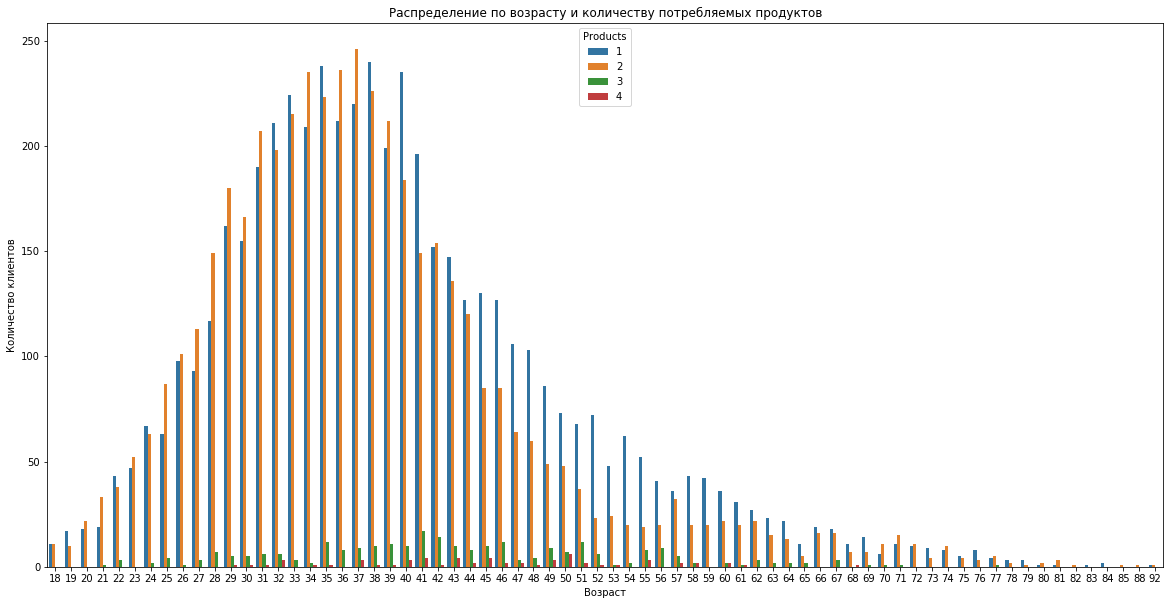

In [20]:
# Построим столбчатые график по признаку пола для клиентов, использующих разное количество продуктов банка
fig = plt.figure(figsize=(20,10))

sns.barplot(data=bank.groupby(['Age', 'Products']).agg({'Objects': 'count'}).reset_index(),
            x='Age',y='Objects',hue='Products');


# Добавим подписи к графику
plt.title('Распределение по возрасту и количеству потребляемых продуктов')
plt.xlabel('Возраст')
plt.ylabel('Количество клиентов');

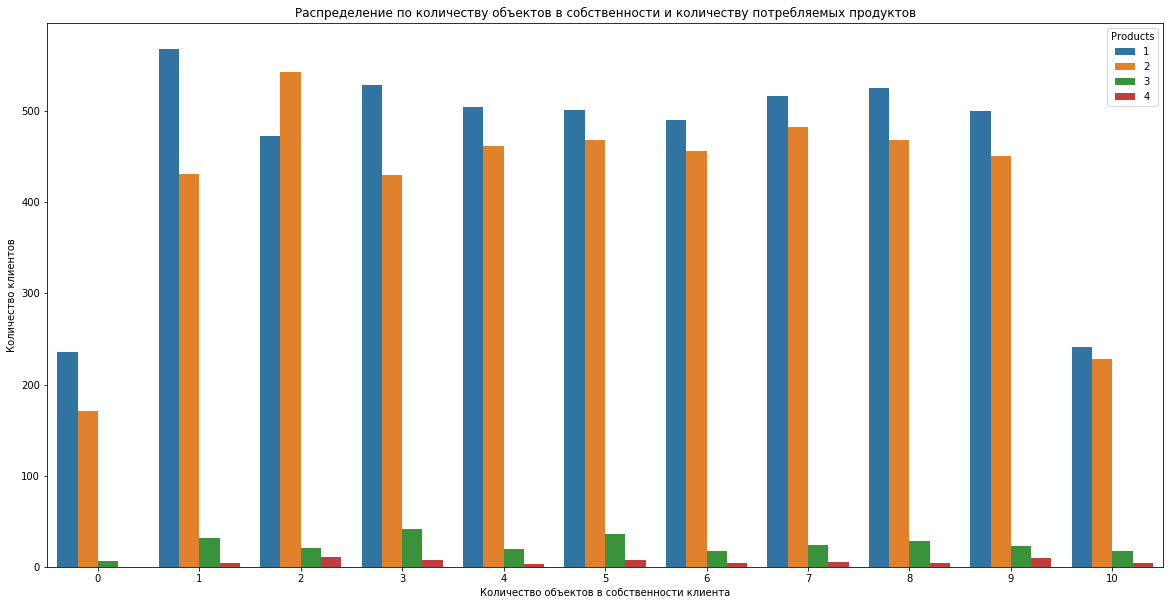

In [21]:
# Построим столбчатые график по признаку количество объектов в собственности для клиентов
# использующих разное количество продуктов банка
fig = plt.figure(figsize=(20,10))

sns.barplot(data=bank.groupby(['Objects', 'Products']).agg({'Age': 'count'}).reset_index(),
            x='Objects',y='Age',hue='Products');


# Добавим подписи к графику
plt.title('Распределение по количеству объектов в собственности и количеству потребляемых продуктов')
plt.xlabel('Количество объектов в собственности клиента')
plt.ylabel('Количество клиентов');

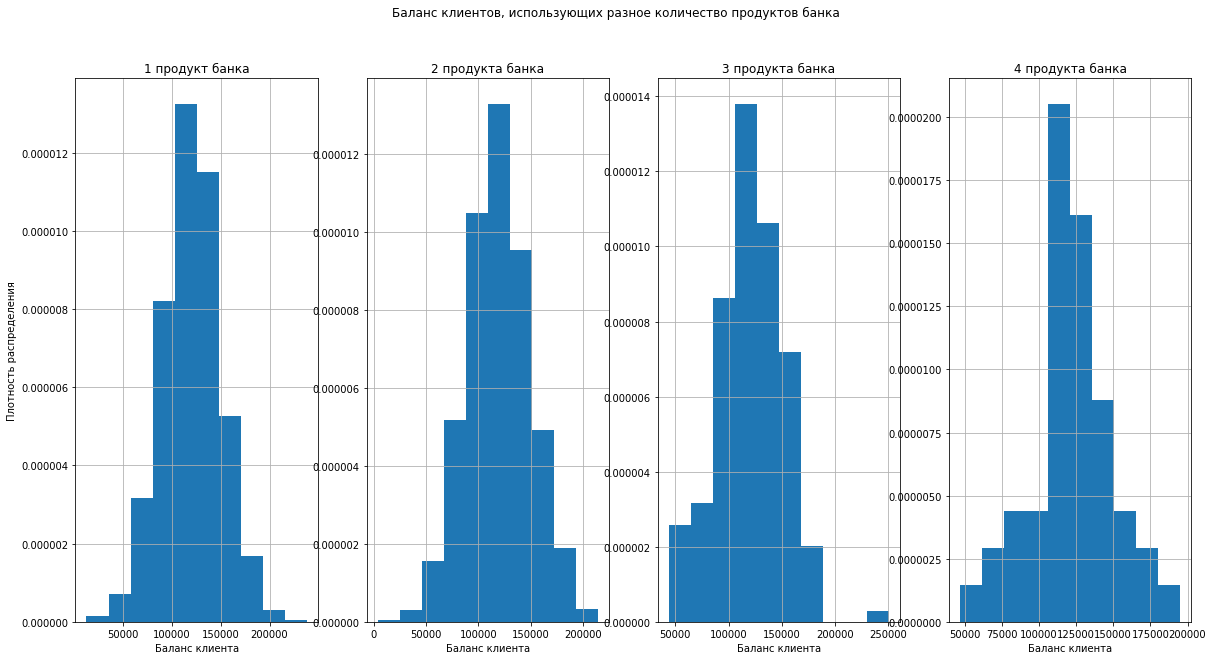

In [22]:
# Создадим рисунок с 4 графиками в ряд
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 10))

# Построим гистрограмму для столбца с годом выпуска

bank_1['Balance'].hist(density=True, ax=axes[0])
bank_2['Balance'].hist(density=True, ax=axes[1])
bank_3['Balance'].hist(density=True, ax=axes[2])
bank_4['Balance'].hist(density=True, ax=axes[3])

# Добавим подписи для каждой колонки 
axes[0].set_title('1 продукт банка')
axes[0].set_xlabel('Баланс клиента')
axes[0].set_ylabel('Плотность распределения')
axes[1].set_title('2 продукта банка')
axes[1].set_xlabel('Баланс клиента')
axes[2].set_title('3 продукта банка')
axes[2].set_xlabel('Баланс клиента')
axes[3].set_title('4 продукта банка')
axes[3].set_xlabel('Баланс клиента')

# Добавим общий заголовок
fig.suptitle('Баланс клиентов, использующих разное количество продуктов банка');

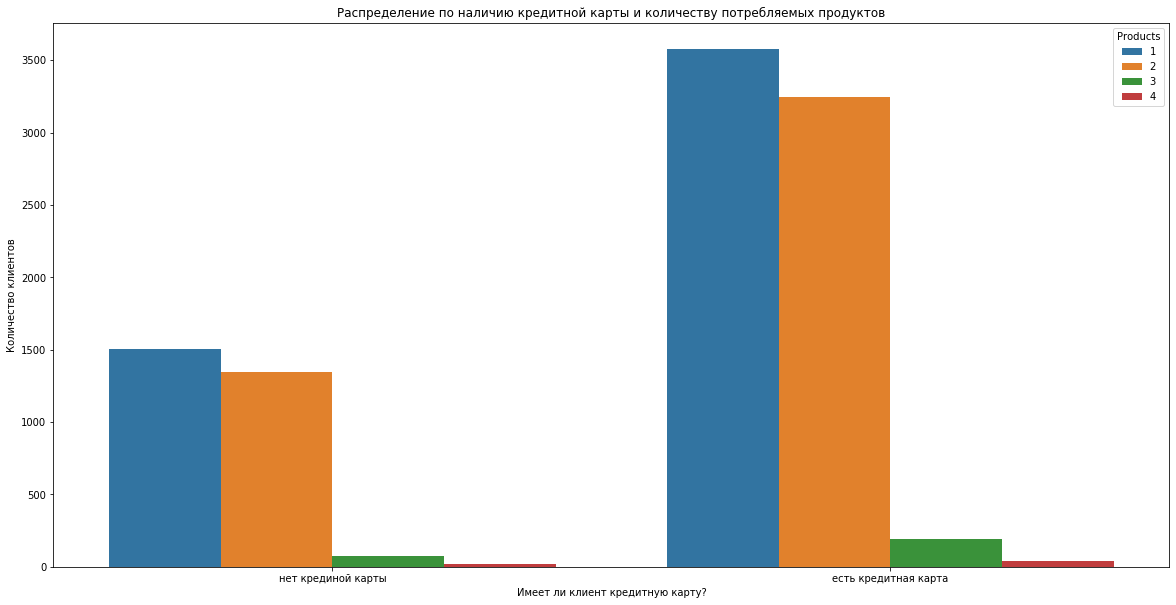

In [23]:
# Построим столбчатые график по признаку наличия кредитной карты
# использующих разное количество продуктов банка
fig = plt.figure(figsize=(20,10))

sns.barplot(data=bank.groupby(['CreditCard', 'Products']).agg({'Age': 'count'}).reset_index(),
            x='CreditCard',y='Age',hue='Products');


# Добавим подписи к графику
plt.title('Распределение по наличию кредитной карты и количеству потребляемых продуктов')
plt.xlabel('Имеет ли клиент кредитную карту?')
plt.ylabel('Количество клиентов')
xlabels = ['нет крединой карты', 'есть кредитная карта']
plt.xticks(range(2),xlabels, rotation=0);

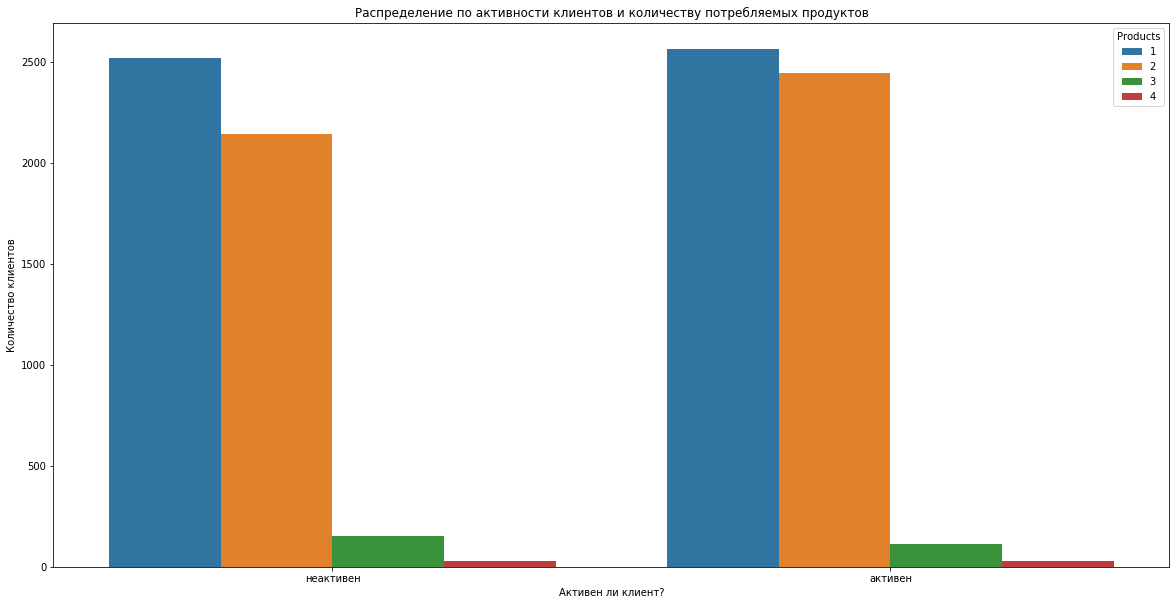

In [24]:
# Построим столбчатые график по признаку активности клиента
# использующих разное количество продуктов банка
fig = plt.figure(figsize=(20,10))

sns.barplot(data=bank.groupby(['Loyalty', 'Products']).agg({'Age': 'count'}).reset_index(),
            x='Loyalty',y='Age',hue='Products');


# Добавим подписи к графику
plt.title('Распределение по активности клиентов и количеству потребляемых продуктов')
plt.xlabel('Активен ли клиент?')
plt.ylabel('Количество клиентов')
xlabels = ['неактивен', 'активен']
plt.xticks(range(2),xlabels, rotation=0);

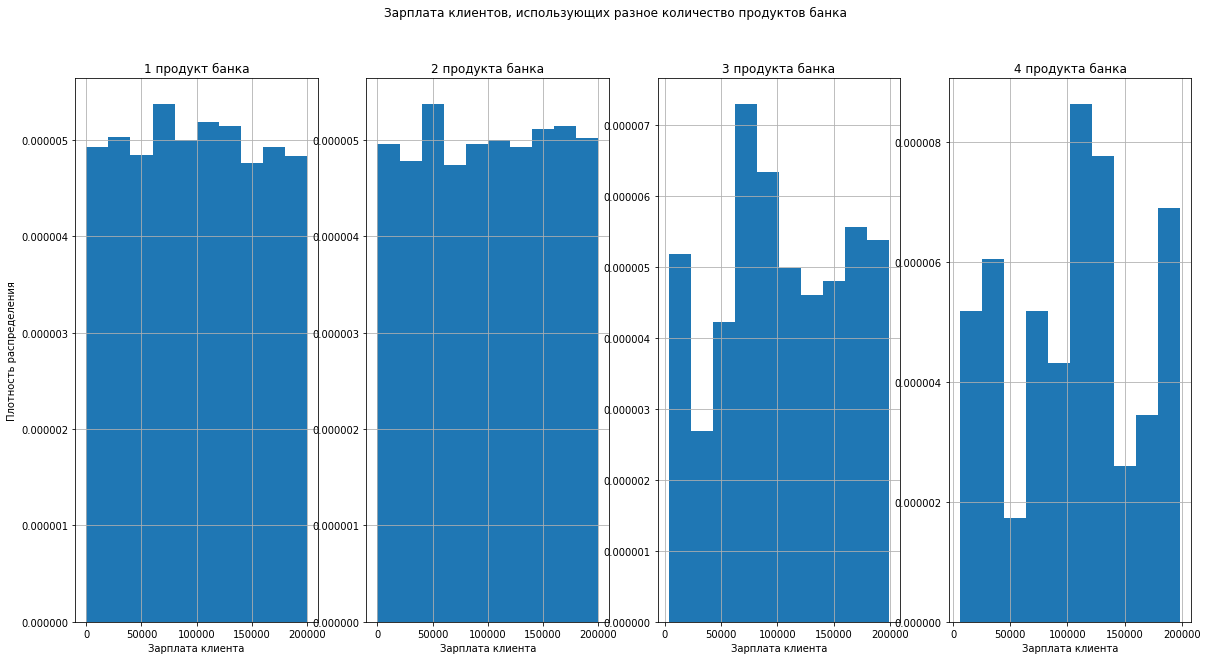

In [25]:
# Создадим рисунок с 4 графиками в ряд
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 10))

# Построим гистрограмму для столбца с годом выпуска

bank_1['estimated_salary'].hist(density=True, ax=axes[0])
bank_2['estimated_salary'].hist(density=True, ax=axes[1])
bank_3['estimated_salary'].hist(density=True, ax=axes[2])
bank_4['estimated_salary'].hist(density=True, ax=axes[3])

# Добавим подписи для каждой колонки 
axes[0].set_title('1 продукт банка')
axes[0].set_xlabel('Зарплата клиента')
axes[0].set_ylabel('Плотность распределения')
axes[1].set_title('2 продукта банка')
axes[1].set_xlabel('Зарплата клиента')
axes[2].set_title('3 продукта банка')
axes[2].set_xlabel('Зарплата клиента')
axes[3].set_title('4 продукта банка')
axes[3].set_xlabel('Зарплата клиента')

# Добавим общий заголовок
fig.suptitle('Зарплата клиентов, использующих разное количество продуктов банка');

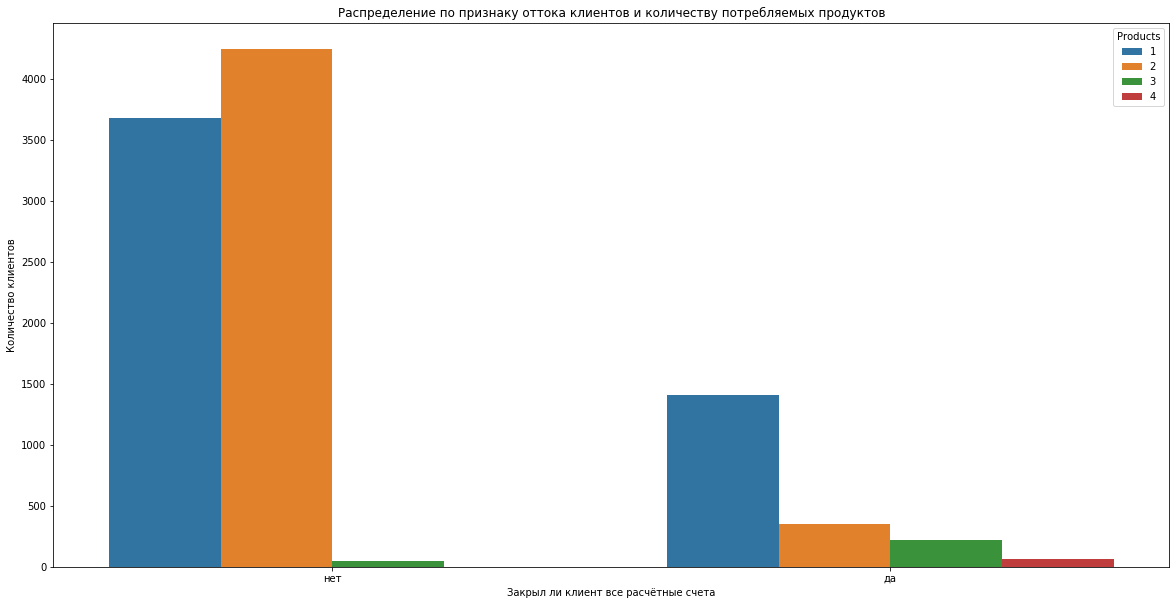

In [26]:
# Построим столбчатые график по признаку оттока клиента
# использующих разное количество продуктов банка
fig = plt.figure(figsize=(20,10))

sns.barplot(data=bank.groupby(['Churn', 'Products']).agg({'Age': 'count'}).reset_index(),
            x='Churn',y='Age',hue='Products');


# Добавим подписи к графику
plt.title('Распределение по признаку оттока клиентов и количеству потребляемых продуктов')
plt.xlabel('Закрыл ли клиент все расчётные счета')
plt.ylabel('Количество клиентов')
xlabels = ['нет', 'да']
plt.xticks(range(2),xlabels, rotation=0);

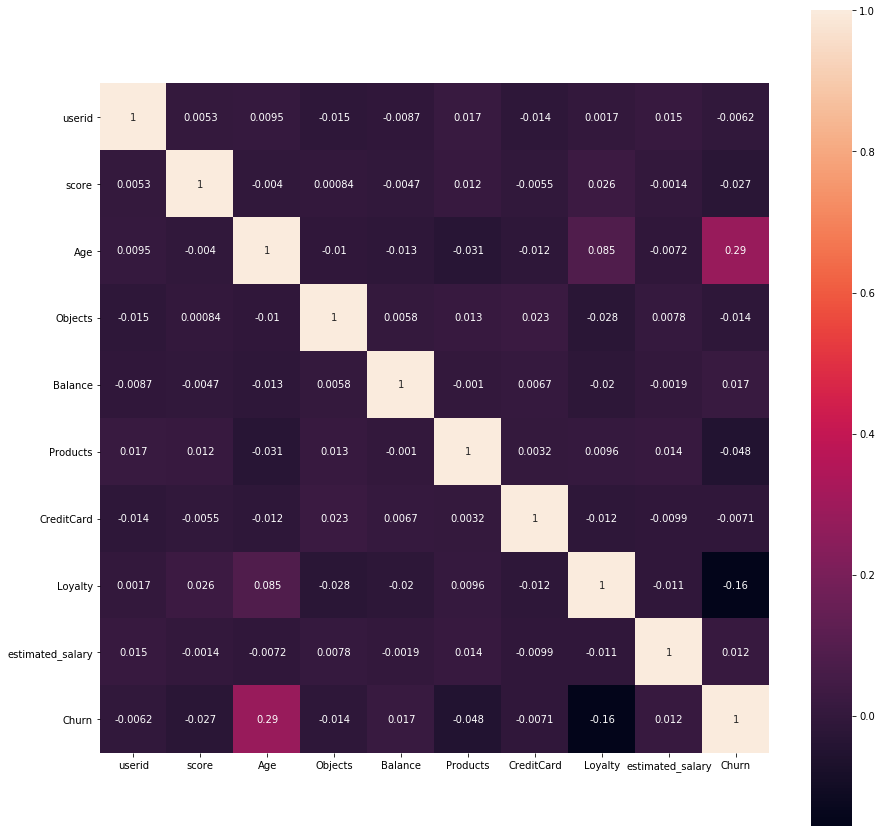

In [27]:
# создадим корреляционную матрицу
corr_bank = bank.corr()

# выведем цветовую карту для корреляционной матрице
plt.figure(figsize = (15,15))
sns.heatmap(corr_bank, square = True, annot = True)
plt.show()

Нет параметров сильно коррелирующих с параметром количества продуктов, которыми пользуется клиент, (Products).

Самый высокий показатель корреляции в нашей таблицы между возрастом и параметром оттока, он составляет 0,29. 

### Вывод

У нас всего 4 продукта, какими могут пользоваться клиенты:

**Группа клиентов, которые пользуются одним продуктом** имеет 5084 человек, 1409 из которых попали в **отток**, что составило **27.71%**. Для группы характерно:

 - Средний и медианный скоринг 650.
 - 49% проживают в Ярославле.
 - 59% клиентов это мужчины.
 - Средний возраст 38-40 лет.
 - Данные клиенты в среднем имеют 5 объектов в собственности.
 - Средний баланс на карте на момент выгрузки составляет 120 000 рублей.
 - 70,38% имеют кредитную карту.
 - 50,41% данной группы активные клиенты.
 - Средняя зарплата данных клиентов составляет 99 200 рублей
 - 1409 клиентов (27,71%) закрыли все свои расчётные счета, из них на момент выгрузки 485 клиентов (9,53%) были активными клиентами на момент выгрузки.

**Группа клиентов, которые пользуются двумя продуктами** имеет 4590 человек, 348 из которых попали в **отток**, что составило **7.58%**. Для группы характерно:

 - Средний и медианный скоринг 652
 - 51,56% проживают в Ярославле.
 - 55% клиентов это мужчины.
 - Средний возраст 36-38 лет.
 - Данные клиенты в среднем имеют 5 объектов в собственности.
 - Средний баланс на карте на момент выгрузки составляет 120 000 рублей.
 - 70,72% имеют кредитную карту.
 - 53,29% данной группы активные клиенты.
 - Средняя зарплата данных клиентов составляет 100 400 рублей
 - 348 клиентов (7,58%) закрыли все свои расчётные счета, из них на момент выгрузки 136 клиентов (2,96%) были активными клиентами на момент выгрузки.

**Группа клиентов, которые пользуются тремя продуктами** имеет 266 человек, 220 из которых попали в **отток**, что составило **82.71%**. Для группы характерно:

 - Средний и медианный скоринг 650
 - 39% проживают в Ярославле.
 - 56% клиентов это женщины.
 - Средний возраст 42-43 лет.
 - Данные клиенты в среднем имеют 5 объектов в собственности.
 - Средний баланс на карте на момент выгрузки составляет 118 200 рублей.
 - 71,43% имеют кредитную карту.
 - 42,48% данной группы активные клиенты.
 - Средняя зарплата данных клиентов составляет 101 000 рублей
 - 220 клиентов (82,71%) закрыли все свои расчётные счета, из них на момент выгрузки 85 клиентов (31,95%) были активными клиентами на момент выгрузки.
 
**Группа клиентов, которые пользуются четырьмя продуктами** имеет 60 человек, 60 из которых попали в **отток**, что составило **100%**. Для группы характерно:

 - Средний и медианный скоринг 643
 - 48,33% проживают в Ярославле.
 - 63,33% клиентов это женщины.
 - Средний возраст 45-46 лет.
 - Данные клиенты в среднем имеют 5 объектов в собственности.
 - Средний баланс на карте на момент выгрузки составляет 121 000 рублей.
 - 68,33% имеют кредитную карту.
 - 48,33% данной группы активные клиенты.
 - Средняя зарплата данных клиентов составляет 112 200 рублей
 - 60 клиентов (100%) закрыли все свои расчётные счета, из них на момент выгрузки 29 клиентов (48,33%) были активными клиентами на момент выгрузки.

## Сформулировать и проверить статистические гипотезы

### Проверим гипотезу о различии доходов между клиентами, которые пользуются двумя продуктами банка, и клиентами, которые пользуются одним.

Так как у нас равномерное распределение, то будем проверять по методу Манн-Уитни.

Сформируем наши гипотезы:

- **Нулевая гипотеза**: между клиентами, использующих 1 и 2 продукта, есть различия в плотности распределения заработной плате.
- **Альтернативная гипотеза**: между клиентами, использующих 1 и 2 продукта, одинаковая плотность распределение в заработной плате.

In [28]:
# Посчитаем статистическую значимость различий в средней заработной плате
alpha = 0.05
results = stats.mannwhitneyu(bank_1['estimated_salary'], bank_2['estimated_salary'], alternative = 'two-sided')[1]
print('p-значение:', results)

if results < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")
    
print('Средняя заработная плата клиентов, использующих 2 продукта, выше',
      'чем средняя заработная плата клиентов, использующих только 1 продукт, на {0:.3f}'.
      format(bank_2['estimated_salary'].mean()/bank_1['estimated_salary'].mean()-1))

p-значение: 0.4079566651927651
Не получилось отвергнуть нулевую гипотезу
Средняя заработная плата клиентов, использующих 2 продукта, выше чем средняя заработная плата клиентов, использующих только 1 продукт, на 0.010


#### Вывод

Мы не отвергаем нулевую гипотезу, о том, что между клиентами, использующих 2 и 1 продукт, есть различия в плотности распределения заработной платы.

Средняя заработная плата клиентов, использующих 2 продукта, выше, средняя заработная плата клиентов, использующих только 1 продукт, на 1%.

### Проверим гипотезу о различии количетсва баллов скоринга, у клиентов, которые пользуются двумя продуктами банка, и клиентами, которые пользуются одним.

Т.к. у нас нормально распределение, то будем проверять по критерию Стьюдента.

Сформируем наши гипотезы:

- **Нулевая гипотеза**: Нет статистически значимых различий в среднем скоринговом балле между клиентами которые пользуются 1 и 2 продуктами.
- **Альтернативная гипотеза**: у клиентов, которые пользуются двумя продуктами банка, и клиентов, которые пользуются одним, есть статистические различия в скоринговой балле.

Нет статистически значимых различий в среднем скоринговом балле между клиентами которые пользуются 1 и 2 продуктами

In [29]:
# Посмотрим на дисперсии наших выборок

# рассчитаем дисперсию для клиентов, использующих только один продукт банка
# Так как выборка в нашей изначальной таблице может быть неполной, то ddorf = 1
dispersion_bank_1 = np.var(bank_1['score'], ddof = 1)

# рассичтаем дисперчию для клиентов, использующих два продукта банка
dispersion_bank_2 = np.var(bank_2['score'], ddof = 1)

# И выведем их на экран
print('Дисперсия клиентам, использующих один продукт банка:', dispersion_bank_1)
print('Дисперсия клиентам, использующих два продукта банка:', dispersion_bank_2)

Дисперсия клиентам, использующих один продукт банка: 9448.56120496532
Дисперсия клиентам, использующих два продукта банка: 9228.836045084605


Т.к. дисперчии не равны, то нужно использовать equal_var = False.

In [30]:
# Выведем на экран средние количество баллов скоринга клиентов использующих 1 и 2 продукта.
print('Среднее количество балло скоринга для клиентов, использующих 1 продукт банка: ', bank_1['score'].mean())
print('Среднее количество балло скоринга для клиентов, использующих 2 продукта банка: ', bank_2['score'].mean())

alpha = 0.05
results = st.ttest_ind(bank_1['score'], bank_2['score'], equal_var = False) 
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Среднее количество балло скоринга для клиентов, использующих 1 продукт банка:  649.1209677419355
Среднее количество балло скоринга для клиентов, использующих 2 продукта банка:  652.1886710239652
p-значение: 0.11889293846062188
Не получилось отвергнуть нулевую гипотезу


#### Вывод

Раз нулевая гипотеза с формулировкой, что у клиентов, которые пользуются двумя продуктами банка, и клиентов, которые пользуются одним, одинаковое количество баллов скоринга, не отвергается, то и опровергнуть мы её не можем.

Выходит, что у клиентов, использующих 1 или 2 продукта, одинаковое количество баллов скоринга.

## Вывод

In [31]:
bank[bank.Churn == 1].describe()

,userid,score,Age,Objects,Balance,Products,CreditCard,Loyalty,estimated_salary,Churn
count,2.037000e+03,2037.000000,2037.000000,2037.000000,1537.000000,2037.000000,2037.000000,2037.000000,2037.000000,2037.0
mean,1.573279e+07,645.351497,44.837997,4.932744,120746.971132,1.475209,0.699067,0.360825,101465.677531,1.0
std,7.269262e+04,100.321503,9.761562,2.936106,30555.192802,0.801521,0.458776,0.480358,57912.418071,0.0
min,1.560844e+07,350.000000,18.000000,0.000000,3768.690000,1.000000,0.000000,0.000000,11.580000,1.0
25%,1.567010e+07,578.000000,38.000000,2.000000,103700.690000,1.000000,0.000000,0.000000,51907.720000,1.0
50%,1.573170e+07,646.000000,45.000000,5.000000,119948.090000,1.000000,1.000000,0.000000,102460.840000,1.0
75%,1.579583e+07,716.000000,51.000000,8.000000,137986.580000,2.000000,1.000000,1.000000,152422.910000,1.0
max,1.585839e+07,850.000000,84.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199808.100000,1.0


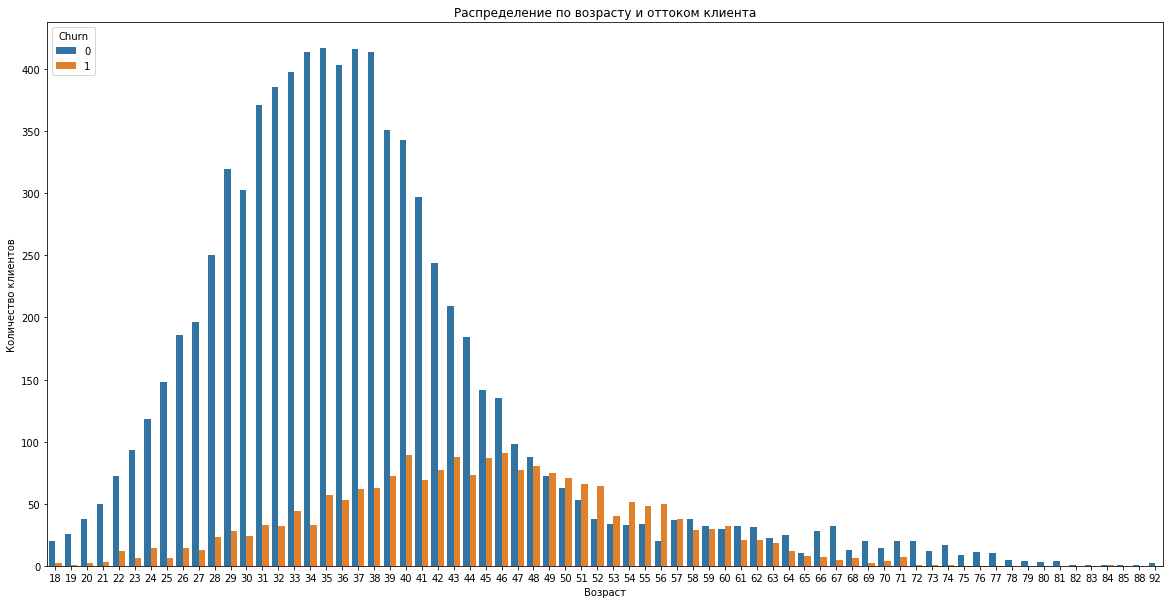

In [32]:
# Построим столбчатые гистограммы по признаку возраста клиентов и их оттоком из банка
fig = plt.figure(figsize=(20,10))

sns.barplot(data=bank.groupby(['Age', 'Churn']).agg({'Objects': 'count'}).reset_index(),
            x='Age',y='Objects',hue='Churn');


# Добавим подписи к графику
plt.title('Распределение по возрасту и оттоком клиента')
plt.xlabel('Возраст')
plt.ylabel('Количество клиентов');

У нас хорошие данные на 10000 клиентов, без дубликатов.

В столбце с балансом есть 3617 пропущенных (36%).Могу предположить следующие причины появления пропусков:

- Есть какое-то количество клиентов, которые не пользуются услугами банка, который подразумевает баланс на счёте. Например, только кредит или ипотека.
- В таблице есть новые клиенты, которые ещё не успели пополнить баланс на момент выгрузки.
- Возможно была и какая-то техническая ошибка при выгрузке.

Можно выделить следующие группы клиентов по количеству потребляемых продуктов:

**Группа клиентов, которые пользуются одним продуктом** имеет 5084 человек, 1409 из которых попали в **отток**, что составило **27.71%**. Для группы характерно:

 - Средний и медианный скоринг 650.
 - 49% проживают в Ярославле.
 - 59% клиентов это мужчины.
 - Средний возраст 38-40 лет.
 - Данные клиенты в среднем имеют 5 объектов в собственности.
 - Средний баланс на карте на момент выгрузки составляет 120 000 рублей.
 - 70,38% имеют кредитную карту.
 - 50,41% данной группы активные клиенты.
 - Средняя зарплата данных клиентов составляет 99 200 рублей
 - 1409 клиентов (27,71%) закрыли все свои расчётные счета, из них на момент выгрузки 485 клиентов (9,53%) были активными клиентами на момент выгрузки.

**Группа клиентов, которые пользуются двумя продуктами** имеет 4590 человек, 348 из которых попали в **отток**, что составило **7.58%**. Для группы характерно:

 - Средний и медианный скоринг 652
 - 51,56% проживают в Ярославле.
 - 55% клиентов это мужчины.
 - Средний возраст 36-38 лет.
 - Данные клиенты в среднем имеют 5 объектов в собственности.
 - Средний баланс на карте на момент выгрузки составляет 120 000 рублей.
 - 70,72% имеют кредитную карту.
 - 53,29% данной группы активные клиенты.
 - Средняя зарплата данных клиентов составляет 100 400 рублей
 - 348 клиентов (7,58%) закрыли все свои расчётные счета, из них на момент выгрузки 136 клиентов (2,96%) были активными клиентами на момент выгрузки.

**Группа клиентов, которые пользуются тремя продуктами** имеет 266 человек, 220 из которых попали в **отток**, что составило **82.71%**. Для группы характерно:

 - Средний и медианный скоринг 650
 - 39% проживают в Ярославле.
 - 56% клиентов это женщины.
 - Средний возраст 42-43 лет.
 - Данные клиенты в среднем имеют 5 объектов в собственности.
 - Средний баланс на карте на момент выгрузки составляет 118 200 рублей.
 - 71,43% имеют кредитную карту.
 - 42,48% данной группы активные клиенты.
 - Средняя зарплата данных клиентов составляет 101 000 рублей
 - 220 клиентов (82,71%) закрыли все свои расчётные счета, из них на момент выгрузки 85 клиентов (31,95%) были активными клиентами на момент выгрузки.
 
**Группа клиентов, которые пользуются четырьмя продуктами** имеет 60 человек, 60 из которых попали в **отток**, что составило **100%**. Для группы характерно:

 - Средний и медианный скоринг 643
 - 48,33% проживают в Ярославле.
 - 63,33% клиентов это женщины.
 - Средний возраст 45-46 лет.
 - Данные клиенты в среднем имеют 5 объектов в собственности.
 - Средний баланс на карте на момент выгрузки составляет 121 000 рублей.
 - 68,33% имеют кредитную карту.
 - 48,33% данной группы активные клиенты.
 - Средняя зарплата данных клиентов составляет 112 200 рублей
 - 60 клиентов (100%) закрыли все свои расчётные счета, из них на момент выгрузки 29 клиентов (48,33%) были активными клиентами на момент выгрузки.
 
Также я проверила две гипотезы:
 - Гипотезу о различии доходов между клиентами, которые пользуются двумя продуктами банка, и клиентами, которые пользуются одним.
 
Между клиентами, использующих 2 и 1 продукт, есть различия в средней заработной плате.

Средняя заработная плата клиентов, использующих 2 продукта, выше, чем средняя заработная плата клиентов, использующих только 1 продукт, на 1%.

- Гипотезу о различии количетсва баллов скоринга, у клиентов, которые пользуются двумя продуктами банка, и клиентами, которые пользуются одним.

По нашей выборке у клиентов, использующих 1 или 2 продукта, одинаковое количество баллов скоринга.

Могу предложить следующие рекомендации:

Так как отток клиентов происходит в основной своей массе в возрасте с 38 до 50 лет и у них в среднем 1 продукт, то стимулировать их подключать дополнительные продукты:
 - Для людей более старшего возраста создать(если нет) или подключать пенсионные проекты. Чтобы им на карточку приходила пенсия, и допустим, чтобы на неё ещё начислялся остаток, по аналогии с дебетовыми картами.
 - Для людей среднего возраста (с 28 до 38 лет) создать или подключать проекты, которые помогут преумножать собственные средства. Инвестиционные и накопительные счета, или же если клиенты бизнесмены, то расширять проекты по кредитованию (наличиными или ипотека) с наименьшими процентами под залог собственности.
 - Также из-за того, что активность клиентов, которые закрыли все расчётные счета, составляет всего 36%, то "проводить профилактику по активности клиентов" на всех этапах пользования клиентом банковских услуг.